Imports

In [1]:
from parameters_U233 import *
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from jitcdde import t
from msrDynamics.objects import Node, System


In [2]:
pows = [0.2,0.5,1.0,5.0,10.0]
sols = []
sols_linear = []
inserted = 4e-4

for p in pows:

    P = p
    T0_g1 = T0_f1 + (k_g * P / hA_fg)
    h_roverall = P / A_rad / ((T0_rp + Trp_in) / 2 - (T0_rs + Trs_in) / 2)
    hA_rpn = h_roverall * A_rad / nn_rs
    hA_rsn = h_roverall * A_rad / nn_rs
    
    MSRE = System()

    # radiator
    T_out_rc = Node(m = mn_rp, scp = mcp_rpn/mn_rp, W = W_rp, y0 = T0_rp)
    T_out_air = Node(m = mn_rs, scp = mcp_rsn/mn_rs, W = W_rs, y0 = T0_rs)

    # heat exchanger
    T_hf1 = Node(m = mn_p, scp = mcp_pn/mn_p, W = W_p, y0 = T0_p1)
    T_hf2 = Node(m = mn_p, scp = mcp_pn/mn_p, W = W_p, y0 = T0_p2)
    T_hf3 = Node(m = mn_p, scp = mcp_pn/mn_p, W = W_p, y0 = T0_p3)
    T_hf4 = Node(m = mn_p, scp = mcp_pn/mn_p, W = W_p, y0 = T0_p4)
    T_ht1 = Node(m = m_tn, scp = scp_t, y0 = T0_t1)
    T_ht2 = Node(m = m_tn, scp = scp_t, y0 = T0_t2)
    T_hc1 = Node(m = mn_s, scp = mcp_sn/mn_s, W = W_s, y0 = T0_s1)
    T_hc2 = Node(m = mn_s, scp = mcp_sn/mn_s, W = W_s, y0 = T0_s2)
    T_hc3 = Node(m = mn_s, scp = mcp_sn/mn_s, W = W_s, y0 = T0_s3)
    T_hc4 = Node(m = mn_s, scp = mcp_sn/mn_s, W = W_s, y0 = T0_s4)

    # core 
    n = Node(y0 = n_frac0)
    C1 = Node(y0 = C0[0])
    C2 = Node(y0 = C0[1])
    C3 = Node(y0 = C0[2])
    C4 = Node(y0 = C0[3])
    C5 = Node(y0 = C0[4])
    C6 = Node(y0 = C0[5])
    rho = Node(y0 = 0.000)

    # add reactivity input
    t_ins = 500
    insert_duration = 0.0
    t_wd = 2500
    def rho_insert(t):
        if (t<t_ins):
            return 0.0
        # elif (t<(t_ins+insert_duration)):
        #     return ((t-t_ins))*(inserted/insert_duration) # linear
        # elif (t < t_wd):
        #     return inserted
        # elif (t < t_wd+insert_duration):
        #     return inserted-((t-t_wd))*(inserted/insert_duration) # linear
        else:
            return inserted

    rho_ext =MSRE.add_input(rho_insert, T)

    T_cg = Node(m = mcp_g1/scp_g, scp = scp_g, y0 = T0_g1)
    T_cf1 = Node(m = mn_f, scp = scp_f, W = W_f, y0 = T0_f1)
    T_cf2 = Node(m = mn_f, scp = scp_f, W = W_f, y0 = T0_f1)

    MSRE.add_nodes([T_out_rc,T_out_air,T_hf1,T_hf2,T_hf3,T_hf4,T_ht1,T_ht2,T_hc1,
                T_hc2,T_hc3,T_hc4,n,C1,C2,C3,C4,C5,C6,T_cg,T_cf1,T_cf2,rho])

    # dynamics 

    # radiator
    T_out_rc.set_dTdt_advective(source = T_hc4.y(t-tau_hx_r))
    T_out_rc.set_dTdt_convective(source = [T_out_air.y()], hA = [hA_rpn])

    T_out_air.set_dTdt_advective(source = Trs_in)
    T_out_air.set_dTdt_convective(source = [T_out_rc.y()], hA = [hA_rsn])

    # heat exchanger
    T_hf1.set_dTdt_advective(source = T_cf2.y(t-tau_c_hx))
    T_hf1.set_dTdt_convective(source = [T_ht1.y()], hA = [hA_pn])

    T_hf2.set_dTdt_advective(source = T_hf1.y())
    T_hf2.set_dTdt_convective(source = [T_ht1.y()], hA = [hA_pn])

    T_hf3.set_dTdt_advective(source = T_hf2.y())
    T_hf3.set_dTdt_convective(source = [T_ht2.y()], hA = [hA_pn])

    T_hf4.set_dTdt_advective(source = T_hf3.y())
    T_hf4.set_dTdt_convective(source = [T_ht2.y()], hA = [hA_pn])

    T_ht1.set_dTdt_convective(source = [T_hf1.y(),T_hf2.y(),T_hc3.y(),T_hc4.y()], hA = [hA_pn,hA_pn,hA_sn,hA_sn])
    T_ht2.set_dTdt_convective(source = [T_hf3.y(),T_hf4.y(),T_hc1.y(),T_hc2.y()], hA = [hA_pn,hA_pn,hA_sn,hA_sn])

    T_hc1.set_dTdt_advective(source = T_out_rc.y(t-tau_r_hx))
    T_hc1.set_dTdt_convective(source = [T_ht2.y()], hA = [hA_sn])

    T_hc2.set_dTdt_advective(source = T_hc1.y())
    T_hc2.set_dTdt_convective(source = [T_ht2.y()], hA = [hA_sn])

    T_hc3.set_dTdt_advective(source = T_hc2.y())
    T_hc3.set_dTdt_convective(source = [T_ht1.y()], hA = [hA_sn])

    T_hc4.set_dTdt_advective(source = T_hc3.y())
    T_hc4.set_dTdt_convective(source = [T_ht1.y()], hA = [hA_sn])

    # core
    n.set_dndt(r = rho.y()+rho_ext, beta_eff = beta_t, Lambda = Lam, lam = lam, C = [C1.y(),C2.y(),C3.y(),C4.y(),C5.y(),C6.y()])
    C1.set_dcdt(n.y(),beta[0],Lam,lam[0],tau_c,tau_l)
    C2.set_dcdt(n.y(),beta[1],Lam,lam[1],tau_c,tau_l)
    C3.set_dcdt(n.y(),beta[2],Lam,lam[2],tau_c,tau_l)
    C4.set_dcdt(n.y(),beta[3],Lam,lam[3],tau_c,tau_l)
    C5.set_dcdt(n.y(),beta[4],Lam,lam[4],tau_c,tau_l)
    C6.set_dcdt(n.y(),beta[5],Lam,lam[5],tau_c,tau_l)

    T_cg.set_dTdt_convective(source = [T_cf1.y()], hA = [hA_fg])
    T_cg.set_dTdt_internal(source = n.y(), k = k_g*P)

    T_cf1.set_dTdt_advective(source = T_hf4.y(t-tau_hx_c))
    T_cf1.set_dTdt_convective(source = [T_cg.y()], hA = [k_1*hA_fg])
    T_cf1.set_dTdt_internal(source = n.y(), k = k_f1*P)

    T_cf2.set_dTdt_advective(source = T_cf1.y())
    T_cf2.set_dTdt_convective(source = [T_cg.y()], hA = [k_2*hA_fg])
    T_cf2.set_dTdt_internal(source = n.y(), k = k_f2*P)

    rho.set_drdt(sources = [T_cf1.dydt(), T_cf2.dydt(), T_cg.dydt()], coeffs = [a_f/2,a_f/2,a_g])

    sols.append(MSRE.solve(T))

for p in pows:

    P = p
    T0_g1 = T0_f1 + (k_g * P / hA_fg)
    h_roverall = P / A_rad / ((T0_rp + Trp_in) / 2 - (T0_rs + Trs_in) / 2)
    hA_rpn = h_roverall * A_rad / nn_rs
    hA_rsn = h_roverall * A_rad / nn_rs
    
    MSRE = System()

    # radiator
    T_out_rc = Node(m = mn_rp, scp = mcp_rpn/mn_rp, W = W_rp, y0 = T0_rp)
    T_out_air = Node(m = mn_rs, scp = mcp_rsn/mn_rs, W = W_rs, y0 = T0_rs)

    # heat exchanger
    T_hf1 = Node(m = mn_p, scp = mcp_pn/mn_p, W = W_p, y0 = T0_p1)
    T_hf2 = Node(m = mn_p, scp = mcp_pn/mn_p, W = W_p, y0 = T0_p2)
    T_hf3 = Node(m = mn_p, scp = mcp_pn/mn_p, W = W_p, y0 = T0_p3)
    T_hf4 = Node(m = mn_p, scp = mcp_pn/mn_p, W = W_p, y0 = T0_p4)
    T_ht1 = Node(m = m_tn, scp = scp_t, y0 = T0_t1)
    T_ht2 = Node(m = m_tn, scp = scp_t, y0 = T0_t2)
    T_hc1 = Node(m = mn_s, scp = mcp_sn/mn_s, W = W_s, y0 = T0_s1)
    T_hc2 = Node(m = mn_s, scp = mcp_sn/mn_s, W = W_s, y0 = T0_s2)
    T_hc3 = Node(m = mn_s, scp = mcp_sn/mn_s, W = W_s, y0 = T0_s3)
    T_hc4 = Node(m = mn_s, scp = mcp_sn/mn_s, W = W_s, y0 = T0_s4)

    # core 
    n = Node(y0 = n_frac0)
    C1 = Node(y0 = C0[0])
    C2 = Node(y0 = C0[1])
    C3 = Node(y0 = C0[2])
    C4 = Node(y0 = C0[3])
    C5 = Node(y0 = C0[4])
    C6 = Node(y0 = C0[5])
    rho = Node(y0 = 0.000)

    # add reactivity input
    t_ins = 500
    insert_duration = 0.0
    t_wd = 2500
    def rho_insert(t):
        if (t<t_ins):
            return 0.0
        # elif (t<(t_ins+insert_duration)):
        #     return ((t-t_ins))*(inserted/insert_duration) # linear
        # elif (t < t_wd):
        #     return inserted
        # elif (t < t_wd+insert_duration):
        #     return inserted-((t-t_wd))*(inserted/insert_duration) # linear
        else:
            return inserted

    rho_ext =MSRE.add_input(rho_insert, T)

    T_cg = Node(m = mcp_g1/scp_g, scp = scp_g, y0 = T0_g1)
    T_cf1 = Node(m = mn_f, scp = scp_f, W = W_f, y0 = T0_f1)
    T_cf2 = Node(m = mn_f, scp = scp_f, W = W_f, y0 = T0_f1)

    MSRE.add_nodes([T_out_rc,T_out_air,T_hf1,T_hf2,T_hf3,T_hf4,T_ht1,T_ht2,T_hc1,
                T_hc2,T_hc3,T_hc4,n,C1,C2,C3,C4,C5,C6,T_cg,T_cf1,T_cf2,rho])

    # dynamics 

    # radiator
    T_out_rc.set_dTdt_advective(source = T_hc4.y(t-tau_hx_r))
    T_out_rc.set_dTdt_convective(source = [T_out_air.y()], hA = [hA_rpn])

    T_out_air.set_dTdt_advective(source = Trs_in)
    T_out_air.set_dTdt_convective(source = [T_out_rc.y()], hA = [hA_rsn])

    # heat exchanger
    T_hf1.set_dTdt_advective(source = T_cf2.y(t-tau_c_hx))
    T_hf1.set_dTdt_convective(source = [T_ht1.y()], hA = [hA_pn])

    T_hf2.set_dTdt_advective(source = T_hf1.y())
    T_hf2.set_dTdt_convective(source = [T_ht1.y()], hA = [hA_pn])

    T_hf3.set_dTdt_advective(source = T_hf2.y())
    T_hf3.set_dTdt_convective(source = [T_ht2.y()], hA = [hA_pn])

    T_hf4.set_dTdt_advective(source = T_hf3.y())
    T_hf4.set_dTdt_convective(source = [T_ht2.y()], hA = [hA_pn])

    T_ht1.set_dTdt_convective(source = [T_hf1.y(),T_hf2.y(),T_hc3.y(),T_hc4.y()], hA = [hA_pn,hA_pn,hA_sn,hA_sn])
    T_ht2.set_dTdt_convective(source = [T_hf3.y(),T_hf4.y(),T_hc1.y(),T_hc2.y()], hA = [hA_pn,hA_pn,hA_sn,hA_sn])

    T_hc1.set_dTdt_advective(source = T_out_rc.y(t-tau_r_hx))
    T_hc1.set_dTdt_convective(source = [T_ht2.y()], hA = [hA_sn])

    T_hc2.set_dTdt_advective(source = T_hc1.y())
    T_hc2.set_dTdt_convective(source = [T_ht2.y()], hA = [hA_sn])

    T_hc3.set_dTdt_advective(source = T_hc2.y())
    T_hc3.set_dTdt_convective(source = [T_ht1.y()], hA = [hA_sn])

    T_hc4.set_dTdt_advective(source = T_hc3.y())
    T_hc4.set_dTdt_convective(source = [T_ht1.y()], hA = [hA_sn])

    # core
    # n.set_dndt(r = rho.y()+rho_ext, beta_eff = beta_t, Lambda = Lam, lam = lam, C = [C1.y(),C2.y(),C3.y(),C4.y(),C5.y(),C6.y()])
    n.dndt = ((rho_0-beta_t)/Lam)*n.y() + lam[0]*C1.y() + lam[1]*C2.y() + lam[2]*C3.y() + lam[3]*C4.y() + lam[4]*C5.y() + lam[5]*C6.y() + (rho.y()+rho_ext)/Lam
    C1.set_dcdt(n.y(),beta[0],Lam,lam[0],tau_c,tau_l)
    C2.set_dcdt(n.y(),beta[1],Lam,lam[1],tau_c,tau_l)
    C3.set_dcdt(n.y(),beta[2],Lam,lam[2],tau_c,tau_l)
    C4.set_dcdt(n.y(),beta[3],Lam,lam[3],tau_c,tau_l)
    C5.set_dcdt(n.y(),beta[4],Lam,lam[4],tau_c,tau_l)
    C6.set_dcdt(n.y(),beta[5],Lam,lam[5],tau_c,tau_l)

    T_cg.set_dTdt_convective(source = [T_cf1.y()], hA = [hA_fg])
    T_cg.set_dTdt_internal(source = n.y(), k = k_g*P)

    T_cf1.set_dTdt_advective(source = T_hf4.y(t-tau_hx_c))
    T_cf1.set_dTdt_convective(source = [T_cg.y()], hA = [k_1*hA_fg])
    T_cf1.set_dTdt_internal(source = n.y(), k = k_f1*P)

    T_cf2.set_dTdt_advective(source = T_cf1.y())
    T_cf2.set_dTdt_convective(source = [T_cg.y()], hA = [k_2*hA_fg])
    T_cf2.set_dTdt_internal(source = n.y(), k = k_f2*P)

    rho.set_drdt(sources = [T_cf1.dydt(), T_cf2.dydt(), T_cg.dydt()], coeffs = [a_f/2,a_f/2,a_g])

    sols_linear.append(MSRE.solve(T))

Generating, compiling, and loading C code.
Using default integration parameters.


/home/luke/git/envs/thesis_env/lib/python3.11/site-packages/jitcdde/_jitcdde.py:795: UserWarning: You did not explicitly handle initial discontinuities. Proceed only if you know what you are doing. This is only fine if you somehow chose your initial past such that the derivative of the last anchor complies with the DDE. In this case, you can set the attribute `initial_discontinuities_handled` to `True` to suppress this warning. See https://jitcdde.rtfd.io/#discontinuities for details.
  warn("You did not explicitly handle initial discontinuities. Proceed only if you know what you are doing. This is only fine if you somehow chose your initial past such that the derivative of the last anchor complies with the DDE. In this case, you can set the attribute `initial_discontinuities_handled` to `True` to suppress this warning. See https://jitcdde.rtfd.io/#discontinuities for details.")
/home/luke/git/envs/thesis_env/lib/python3.11/site-packages/jitcdde/_jitcdde.py:795: UserWarning: You did no

Generating, compiling, and loading C code.
Using default integration parameters.
Generating, compiling, and loading C code.
Using default integration parameters.
Generating, compiling, and loading C code.
Using default integration parameters.
Generating, compiling, and loading C code.
Using default integration parameters.
Generating, compiling, and loading C code.
Using default integration parameters.
Generating, compiling, and loading C code.
Using default integration parameters.
Generating, compiling, and loading C code.
Using default integration parameters.
Generating, compiling, and loading C code.
Using default integration parameters.
Generating, compiling, and loading C code.
Using default integration parameters.


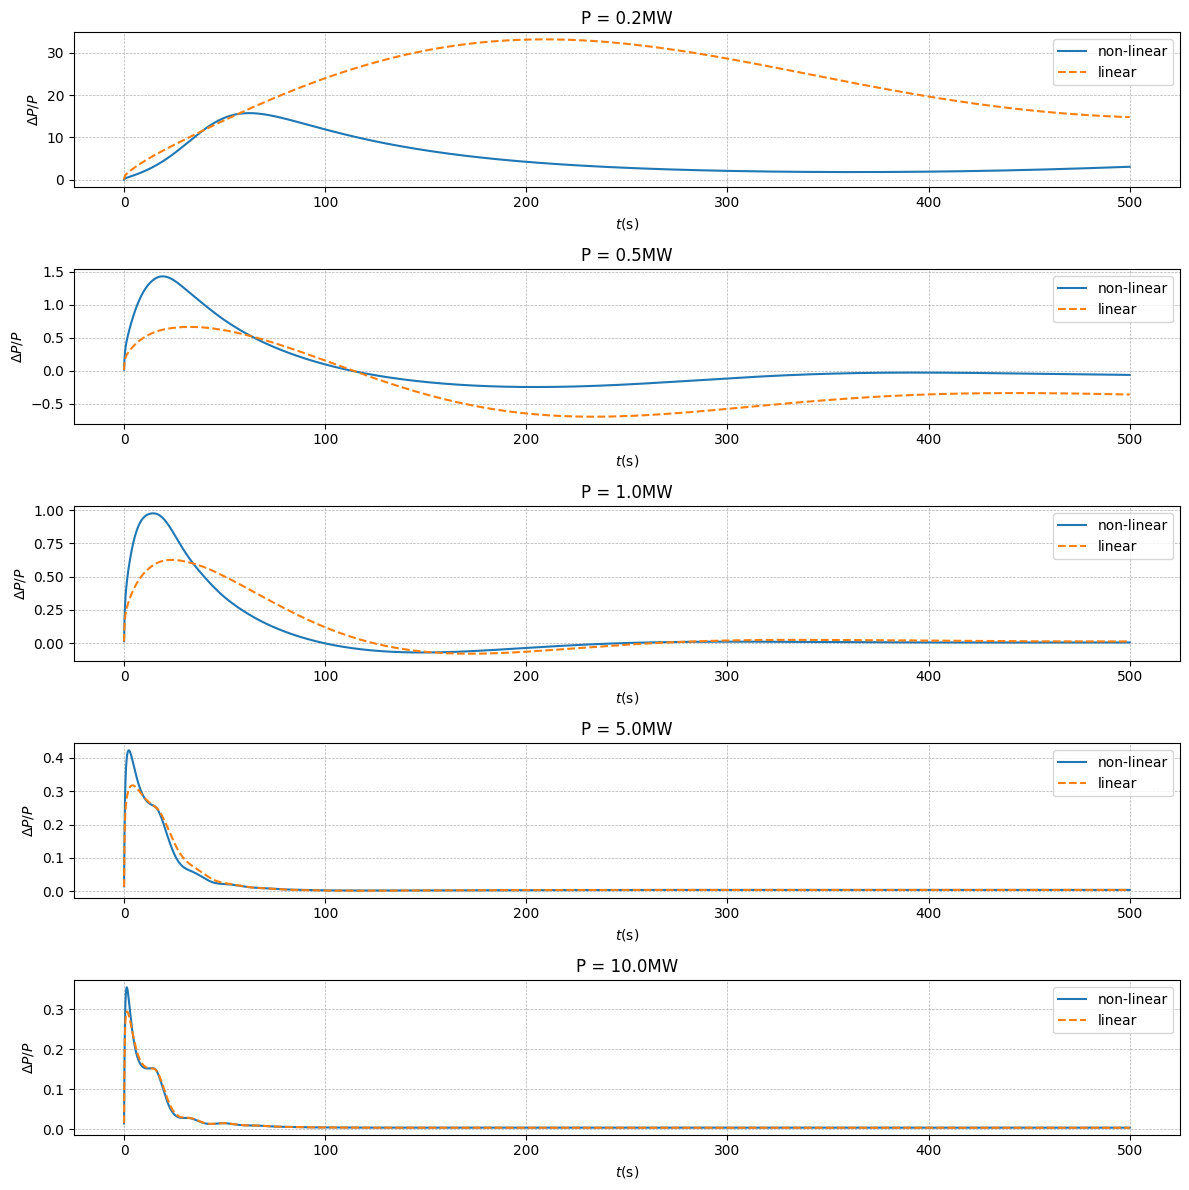

In [3]:


fig,axs = plt.subplots(len(pows),1,figsize=(12,12))

colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown']

# function to update the style of each axis
def update_axis_style(ax, title, x_label='', y_label='', x_ticks=True):
    ax.set_title(title)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.grid(True, which='both', linestyle='--', linewidth=0.5)
    ax.tick_params(axis='x', which='both', bottom=x_ticks, top=False, labelbottom=x_ticks)
    ax.tick_params(axis='y', which='both', left=True, right=False, labelleft=True)


t_start = 500
t_end = 1000
i_plot = [i for i in range(len(T)) if (T[i] > t_start) and (T[i] < t_end)]

for p in enumerate(pows):
    n_run = np.array([s[n.index] for s in sols[p[0]]])
    p_run = pows[p[0]]*n_run
    p_ss = p_run[i_plot[0]-10]

    n_run_l = np.array([s[n.index] for s in sols_linear[p[0]]])
    p_run_l = pows[p[0]]*n_run_l
    p_ss_l = p_run_l[i_plot[0]-10]

    axs[p[0]].plot(T[i_plot]-t_ins,(p_run[i_plot]-p_ss)/p_ss,label="non-linear")
    axs[p[0]].plot(T[i_plot]-t_ins,(p_run_l[i_plot]-p_ss_l)/p_ss,linestyle="--",label="linear")
    axs[p[0]].legend()
    update_axis_style(axs[p[0]],f"P = {pows[p[0]]}MW",x_label=r"$t$(s)",y_label=r"$\Delta P/P$")

plt.tight_layout()
